In [1]:
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn import tree
from chefboost import Chefboost as chef
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.model_selection import KFold



In [2]:
df = pd.read_csv("kidney_rsi.csv")

In [3]:
df.head()

,bp,sg,al,su,rbc,pc,pcc,ba,bgr,sc,hemo,pcv,wc,rc,htn,dm,classification
0,80.0,1.020,1.0,0.0,NaN,normal,tidakada,tidakada,121.0,1.2,15.4,44.0,7800.0,5.2,yes,yes,ckd
1,50.0,1.020,4.0,0.0,NaN,normal,tidakada,tidakada,NaN,0.8,11.3,38.0,6000.0,NaN,no,no,ckd
2,80.0,1.010,2.0,3.0,normal,normal,tidakada,tidakada,423.0,1.8,9.6,31.0,7500.0,NaN,no,yes,ckd
3,70.0,1.005,4.0,0.0,normal,abnormal,ada,tidakada,117.0,3.8,11.2,32.0,6700.0,3.9,yes,no,ckd
4,80.0,1.010,2.0,0.0,normal,normal,tidakada,tidakada,106.0,1.4,11.6,35.0,7300.0,4.6,no,no,ckd


In [4]:
numerical = []
catgoals = []

for col in df.columns:
    if df[col].dtype == 'float64':
        numerical.append(col)
    else:
        catgoals.append(col)

for col in df.columns:
    if col in numerical:
        df.fillna({col: df[col].median()}, inplace=True)
    else:
        df.fillna({col: df[col].mode()[0]}, inplace=True)

In [5]:
numerical

['sg', 'al', 'su', 'bgr', 'sc', 'hemo', 'pcv', 'wc', 'rc']

In [6]:
catgoals

['bp', 'rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'classification']

In [7]:
le = LabelEncoder()
for col in catgoals:
    df[col] = le.fit_transform(df[col])

In [8]:
ind_col = [col for col in df.columns if col != 'classification']
dep_col = 'classification'

In [9]:
df['classification'] = le.fit_transform(df['classification'])

In [10]:
df.head()

,bp,sg,al,su,rbc,pc,pcc,ba,bgr,sc,hemo,pcv,wc,rc,htn,dm,classification
0,17,1.020,1.0,0.0,1,1,1,1,121.0,1.2,15.4,44.0,7800.0,5.2,1,2,0
1,10,1.020,4.0,0.0,1,1,1,1,121.0,0.8,11.3,38.0,6000.0,4.8,0,1,0
2,17,1.010,2.0,3.0,1,1,1,1,423.0,1.8,9.6,31.0,7500.0,4.8,0,2,0
3,13,1.005,4.0,0.0,1,0,0,1,117.0,3.8,11.2,32.0,6700.0,3.9,1,1,0
4,17,1.010,2.0,0.0,1,1,1,1,106.0,1.4,11.6,35.0,7300.0,4.6,0,1,0


pre prosessing

In [11]:
x = df[ind_col]
y = df[dep_col]

Transform data

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

Nilai ccp_alpha optimal: 0.01342323740697728
Mean cross-validation score: 0.9642857142857144


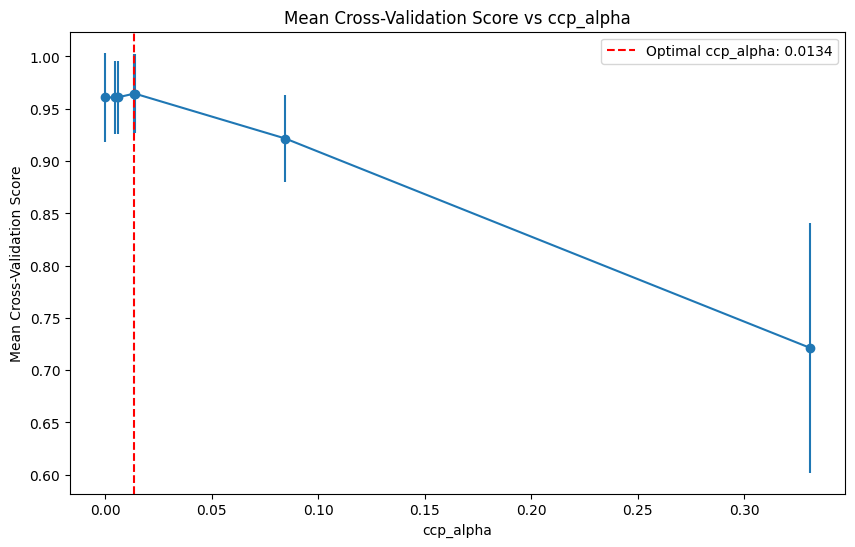

In [13]:
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(x_train, y_train)

path = decision_tree.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

alpha_results = []

for ccp_alpha in ccp_alphas:
    dt = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    scores = cross_val_score(dt, x_train, y_train, cv=5)
    alpha_results.append((ccp_alpha, np.mean(scores), np.std(scores)))

alpha_results = np.array(alpha_results)
ccp_alphas = alpha_results[:, 0]
mean_scores = alpha_results[:, 1]
std_scores = alpha_results[:, 2]

optimal_idx = np.argmax(mean_scores)
optimal_alpha = ccp_alphas[optimal_idx]
optimal_score = mean_scores[optimal_idx]

print(f"Nilai ccp_alpha optimal: {optimal_alpha}")
print(f"Mean cross-validation score: {optimal_score}")

plt.figure(figsize=(10, 6))
plt.errorbar(ccp_alphas, mean_scores, yerr=std_scores, fmt='-o')
plt.axvline(x=optimal_alpha, color='r', linestyle='--', label=f'Optimal ccp_alpha: {optimal_alpha:.4f}')
plt.xlabel('ccp_alpha')
plt.ylabel('Mean Cross-Validation Score')
plt.title('Mean Cross-Validation Score vs ccp_alpha')
plt.legend()
plt.show()

Akurasi data training (pruned) = 97.85714285714285
Akurasi data testing (pruned) = 99.16666666666667 

Confusion matrix (pruned): 
[[75  1]
 [ 0 44]] 

Classification report (pruned): 
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       174
           1       1.00      0.94      0.97       106

    accuracy                           0.98       280
   macro avg       0.98      0.97      0.98       280
weighted avg       0.98      0.98      0.98       280

Cross-validation scores (pruned):
Fold 1: 0.9643
Fold 2: 0.9643
Fold 3: 0.9286
Fold 4: 1.0000
Fold 5: 0.9643
Fold 6: 1.0000
Fold 7: 0.9643
Fold 8: 0.9643
Fold 9: 0.8571
Fold 10: 1.0000
Mean cross-validation score (pruned): 0.9607142857142857
Standard deviation of cross-validation scores (pruned): 0.04056363104143054
Akurasi data training (unpruned) = 100.0
Akurasi data testing (unpruned) = 99.16666666666667 

Confusion matrix (unpruned): 
[[75  1]
 [ 0 44]] 

Classification report (u

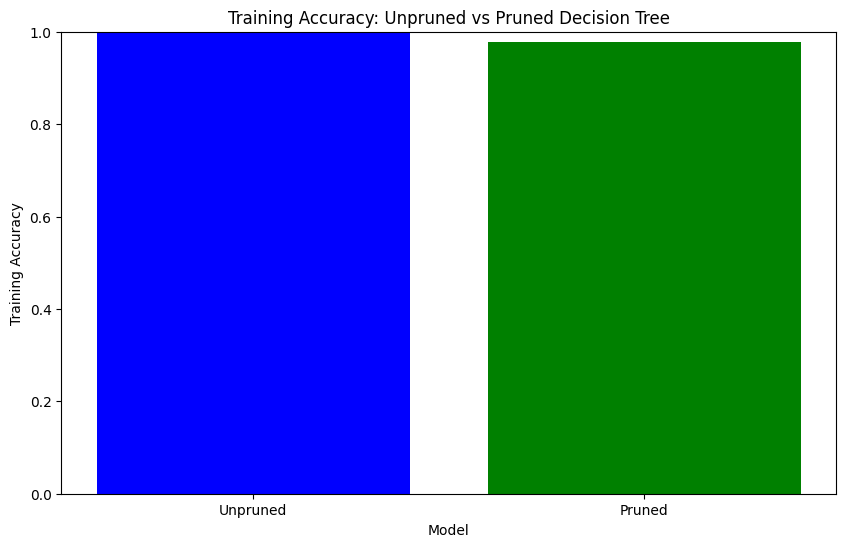

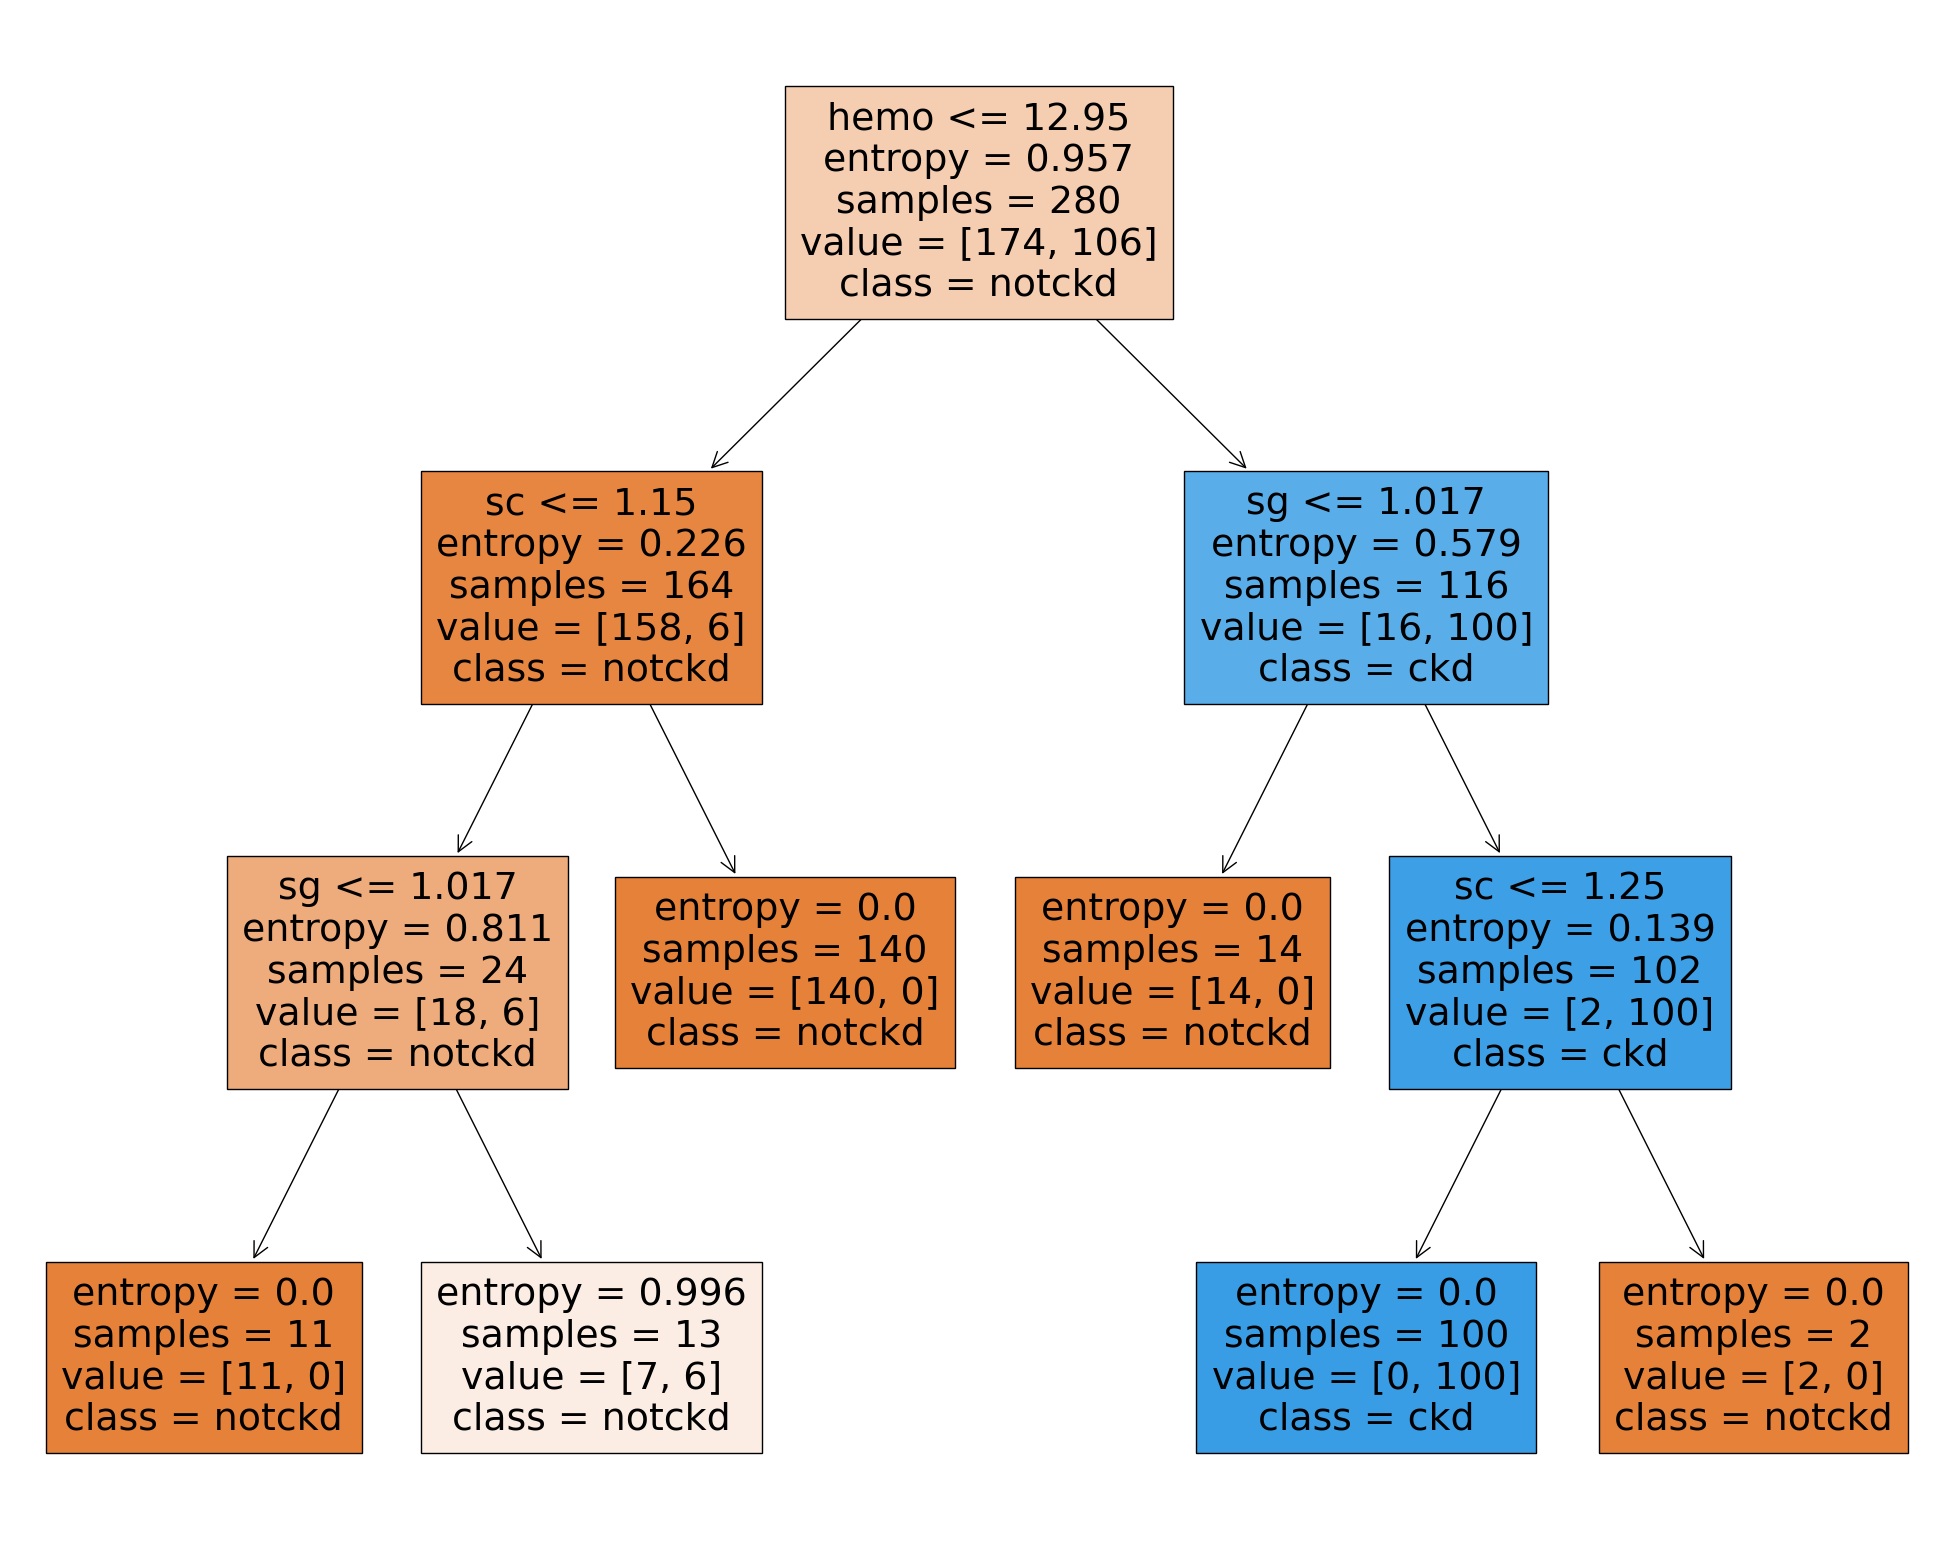

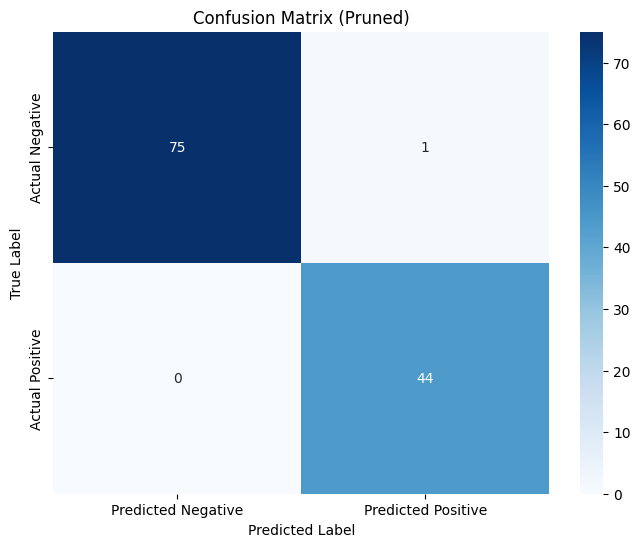

In [14]:
dtc_pruned = DecisionTreeClassifier(
    criterion='entropy',
    ccp_alpha=0.0134,
    max_depth=3,
    class_weight=None,
    max_features=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0, 
    min_samples_leaf=1,
    min_samples_split=2, 
    min_weight_fraction_leaf=0.0,
    random_state=42,
    splitter='best'
)

model_pruned = dtc_pruned.fit(x_train, y_train)
dtc_pruned_acc = accuracy_score(y_test, dtc_pruned.predict(x_test))
kf = KFold(n_splits=10, shuffle=True, random_state=42)
cv_results_pruned = cross_val_score(model_pruned, x_train, y_train, cv=kf, scoring='accuracy')

print(f"Akurasi data training (pruned) = {accuracy_score(y_train, dtc_pruned.predict(x_train)) * 100}")
print(f"Akurasi data testing (pruned) = {dtc_pruned_acc * 100} \n")

confusion_pruned = confusion_matrix(y_test, dtc_pruned.predict(x_test))
print(f"Confusion matrix (pruned): \n{confusion_pruned} \n")
print(f"Classification report (pruned): \n{classification_report(y_train, dtc_pruned.predict(x_train))}")

print('Cross-validation scores (pruned):')
for i, score in enumerate(cv_results_pruned, 1):
    print(f'Fold {i}: {score:.4f}')
print(f'Mean cross-validation score (pruned): {np.mean(cv_results_pruned)}')
print(f'Standard deviation of cross-validation scores (pruned): {np.std(cv_results_pruned)}')

dtc_unpruned = DecisionTreeClassifier()

model_unpruned = dtc_unpruned.fit(x_train, y_train)
dtc_unpruned_acc = accuracy_score(y_test, dtc_unpruned.predict(x_test))
cv_results_unpruned = cross_val_score(model_unpruned, x_train, y_train, cv=kf, scoring='accuracy')

print(f"Akurasi data training (unpruned) = {accuracy_score(y_train, dtc_unpruned.predict(x_train)) * 100}")
print(f"Akurasi data testing (unpruned) = {dtc_unpruned_acc * 100} \n")

confusion_unpruned = confusion_matrix(y_test, dtc_unpruned.predict(x_test))
print(f"Confusion matrix (unpruned): \n{confusion_unpruned} \n")
print(f"Classification report (unpruned): \n{classification_report(y_train, dtc_unpruned.predict(x_train))}")

print('Cross-validation scores (unpruned):')
for i, score in enumerate(cv_results_unpruned, 1):
    print(f'Fold {i}: {score:.4f}')
print(f'Mean cross-validation score (unpruned): {np.mean(cv_results_unpruned)}')
print(f'Standard deviation of cross-validation scores (unpruned): {np.std(cv_results_unpruned)}')

plt.figure(figsize=(10, 6))
plt.bar(['Unpruned', 'Pruned'], 
        [accuracy_score(y_train, dtc_unpruned.predict(x_train)), accuracy_score(y_train, dtc_pruned.predict(x_train))],
        color=['blue', 'green'])
plt.xlabel('Model')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy: Unpruned vs Pruned Decision Tree')
plt.ylim(0, 1)
plt.show()

fig = plt.figure(figsize=(25, 20))
_ = tree.plot_tree(model_pruned, feature_names=ind_col, class_names=['notckd', 'ckd'], filled=True)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_pruned, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix (Pruned)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



Akurasi data training = 97.86%
Akurasi data testing = 99.17% 

Confusion Matrix: 
[[75  1]
 [ 0 44]] 

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        76
           1       0.98      1.00      0.99        44

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120

Cross-validation scores:
Fold 1: 0.9643
Fold 2: 0.9643
Fold 3: 0.9286
Fold 4: 1.0000
Fold 5: 0.9643
Fold 6: 1.0000
Fold 7: 0.9643
Fold 8: 0.9643
Fold 9: 0.8571
Fold 10: 1.0000
Mean cross-validation score: 0.9607
Standard deviation of cross-validation scores: 0.0406


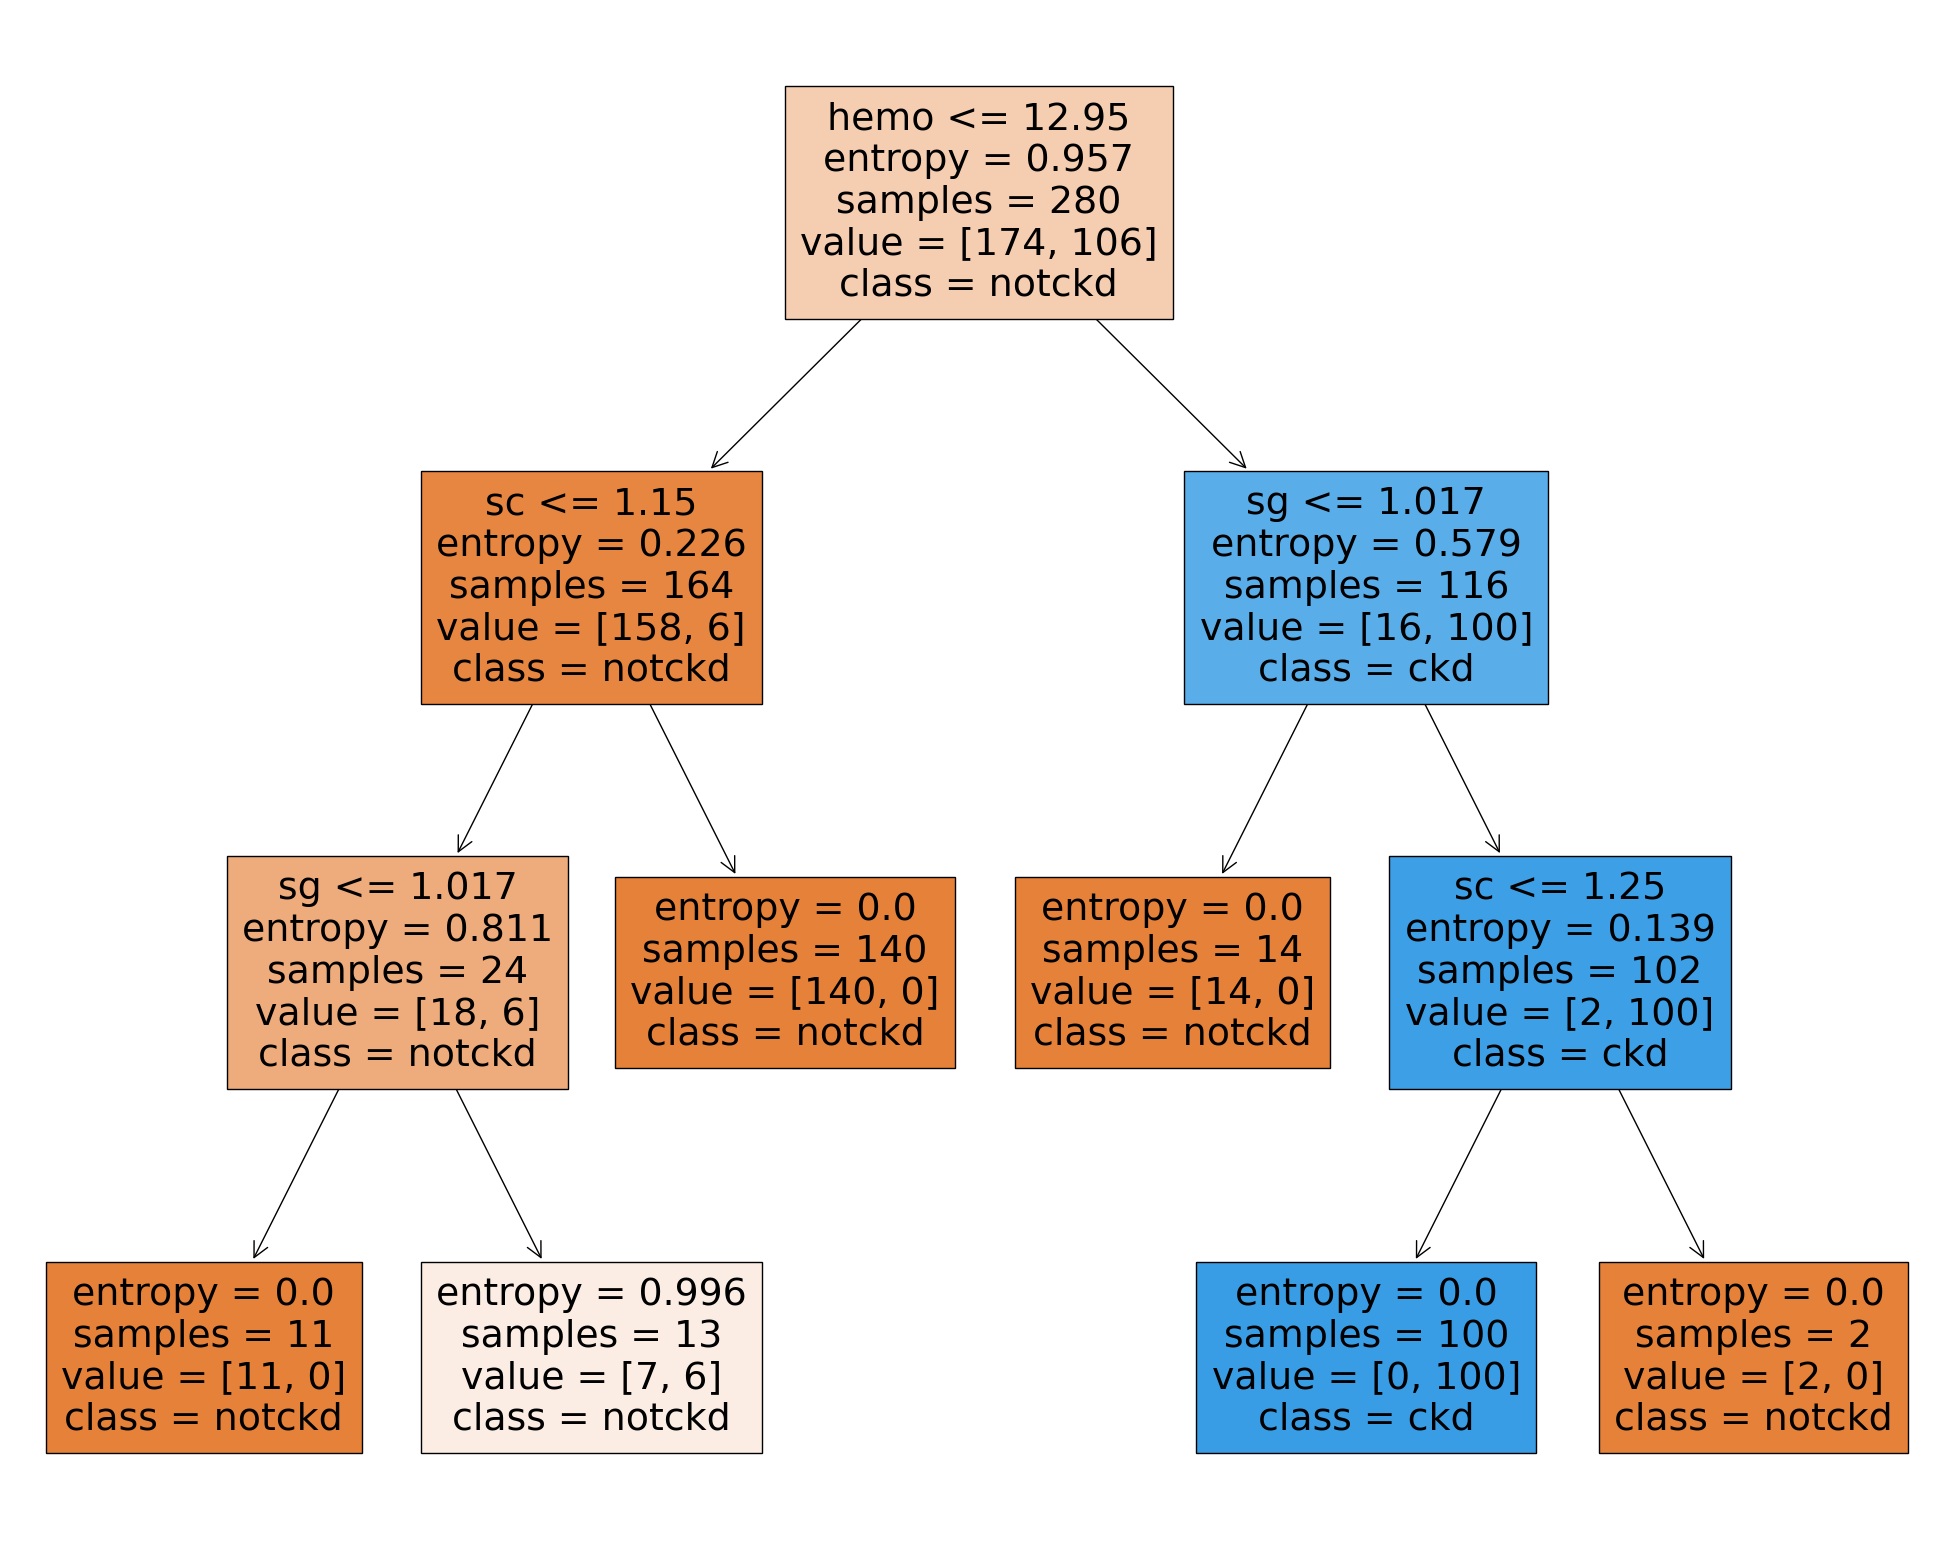

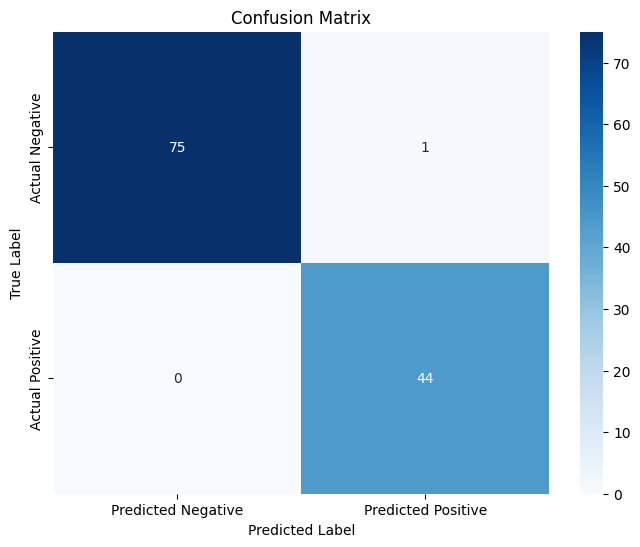

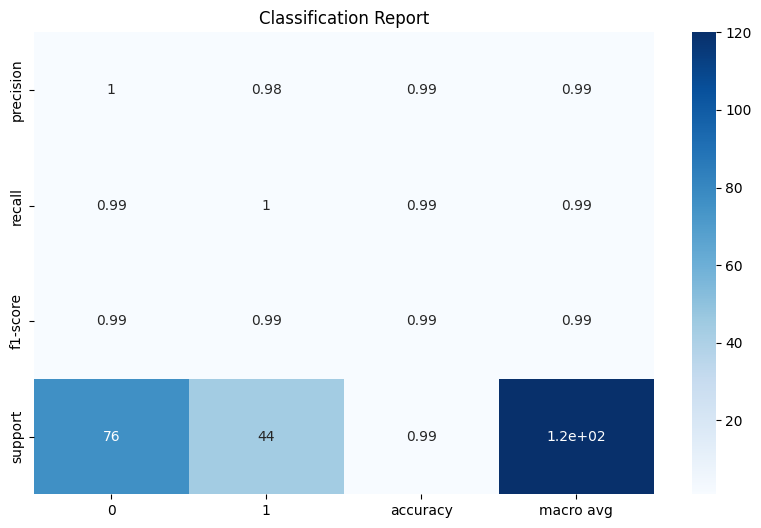

Time taken for fitting model: 0.0024171000 seconds
Time taken for prediction: 0.0016928000 seconds


In [15]:
# dtc = DecisionTreeClassifier(
#     criterion='entropy',
#     ccp_alpha=0.0134,
#     max_depth=3,
#     class_weight=None,
#     max_features=None,
#     max_leaf_nodes=None,
#     min_impurity_decrease=0.0, 
#     min_samples_leaf=1,
#     min_samples_split=2, 
#     min_weight_fraction_leaf=0.0,
#     random_state=42,
#     splitter='best'
# )

# model = dtc.fit(x_train, y_train)
# dtc_acc = accuracy_score(y_test, dtc.predict(x_test))

# kf = KFold(n_splits=10, shuffle=True, random_state=42)
# cv_results = cross_val_score(model, x_train, y_train, cv=kf, scoring='accuracy')

# print(f"Akurasi data training = {accuracy_score(y_train, dtc.predict(x_train)) * 100:.2f}%")
# print(f"Akurasi data testing = {dtc_acc * 100:.2f}% \n")

# confusion = confusion_matrix(y_train, dtc.predict(x_train))
# tn, fp, fn, tp = confusion.ravel()
# print(f"Confusion Matrix: \n{confusion} \n")
# print(f"Classification Report: \n{classification_report(y_train, dtc.predict(x_train))}")

# print('Cross-validation scores:')
# for i, score in enumerate(cv_results, 1):
#     print(f'Fold {i}: {score:.4f}')
# print(f'Mean cross-validation score: {np.mean(cv_results):.4f}')
# print(f'Standard deviation of cross-validation scores: {np.std(cv_results):.4f}')

# fig = plt.figure(figsize=(25, 20))
# _ = tree.plot_tree(model, feature_names=ind_col, class_names=['notckd', 'ckd'], filled=True)

# plt.figure(figsize=(8, 6))
# sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.show()

# classification_rep = classification_report(y_train, dtc.predict(x_train), output_dict=True)
# classification_df = pd.DataFrame(classification_rep).transpose()

# plt.figure(figsize=(10, 6))
# sns.heatmap(classification_df.iloc[:-1, :].T, annot=True, cmap='Blues')
# plt.title('Classification Report')
# plt.show()

import time
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn import tree
import seaborn as sns

# Inisialisasi model yang sudah di-pruning
dtc = DecisionTreeClassifier(
    criterion='entropy',
    ccp_alpha=0.0134,
    max_depth=3,
    class_weight=None,
    max_features=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0, 
    min_samples_leaf=1,
    min_samples_split=2, 
    min_weight_fraction_leaf=0.0,
    random_state=42,
    splitter='best'
)

# Mengukur waktu untuk fitting model
start_time = time.perf_counter()
model = dtc.fit(x_train, y_train)
end_time = time.perf_counter()
fit_time = end_time - start_time

# Mengukur waktu untuk prediksi
start_time = time.perf_counter()
y_pred = dtc.predict(x_test)
end_time = time.perf_counter()
predict_time = end_time - start_time

# Evaluasi performa model
dtc_acc = accuracy_score(y_test, y_pred)

kf = KFold(n_splits=10, shuffle=True, random_state=42)
cv_results = cross_val_score(model, x_train, y_train, cv=kf, scoring='accuracy')

print(f"Akurasi data training = {accuracy_score(y_train, dtc.predict(x_train)) * 100:.2f}%")
print(f"Akurasi data testing = {dtc_acc * 100:.2f}% \n")

confusion = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion.ravel()
print(f"Confusion Matrix: \n{confusion} \n")
print(f"Classification Report: \n{classification_report(y_test, y_pred)}")

print('Cross-validation scores:')
for i, score in enumerate(cv_results, 1):
    print(f'Fold {i}: {score:.4f}')
print(f'Mean cross-validation score: {np.mean(cv_results):.4f}')
print(f'Standard deviation of cross-validation scores: {np.std(cv_results):.4f}')

fig = plt.figure(figsize=(25, 20))
_ = tree.plot_tree(model, feature_names=ind_col, class_names=['notckd', 'ckd'], filled=True)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

classification_rep = classification_report(y_test, y_pred, output_dict=True)
classification_df = pd.DataFrame(classification_rep).transpose()

plt.figure(figsize=(10, 6))
sns.heatmap(classification_df.iloc[:-1, :].T, annot=True, cmap='Blues')
plt.title('Classification Report')
plt.show()

# Menampilkan waktu eksekusi
print(f"Time taken for fitting model: {fit_time:.10f} seconds")
print(f"Time taken for prediction: {predict_time:.10f} seconds")



implement with prune

Akurasi data training: 97.86%
Confusion Matrix untuk data training: 
[[174   0]
 [  6 100]]

Classification Report untuk data training: 
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       174
           1       1.00      0.94      0.97       106

    accuracy                           0.98       280
   macro avg       0.98      0.97      0.98       280
weighted avg       0.98      0.98      0.98       280



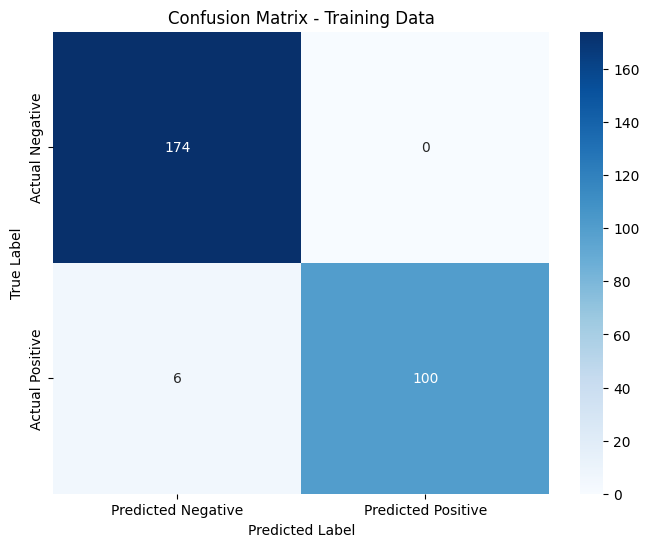

In [16]:
y_train_pred = dtc.predict(x_train)

train_acc = accuracy_score(y_train, y_train_pred)
print(f"Akurasi data training: {train_acc * 100:.2f}%")

confusion_train = confusion_matrix(y_train, y_train_pred)
tn_train, fp_train, fn_train, tp_train = confusion_train.ravel()

# Cetak confusion matrix dan laporan klasifikasi untuk data training
print(f"Confusion Matrix untuk data training: \n{confusion_train}\n")
print(f"Classification Report untuk data training: \n{classification_report(y_train, y_train_pred)}")

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_train, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix - Training Data')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

implement without prune

Cross-validation scores: [0.96428571 0.98214286 0.92857143 1.         0.89285714]
Mean cross-validation score: 95.35714285714286
Time taken for cross-validation: 0.0260237000 seconds
Time taken for fitting model: 0.0017338000 seconds
Time taken for prediction: 0.0009304000 seconds
akurasi data training = 100.00
akurasi data testing = 98.33 

confusion matrix : 
[[74  2]
 [ 0 44]] 

classification report : 
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        76
           1       0.96      1.00      0.98        44

    accuracy                           0.98       120
   macro avg       0.98      0.99      0.98       120
weighted avg       0.98      0.98      0.98       120



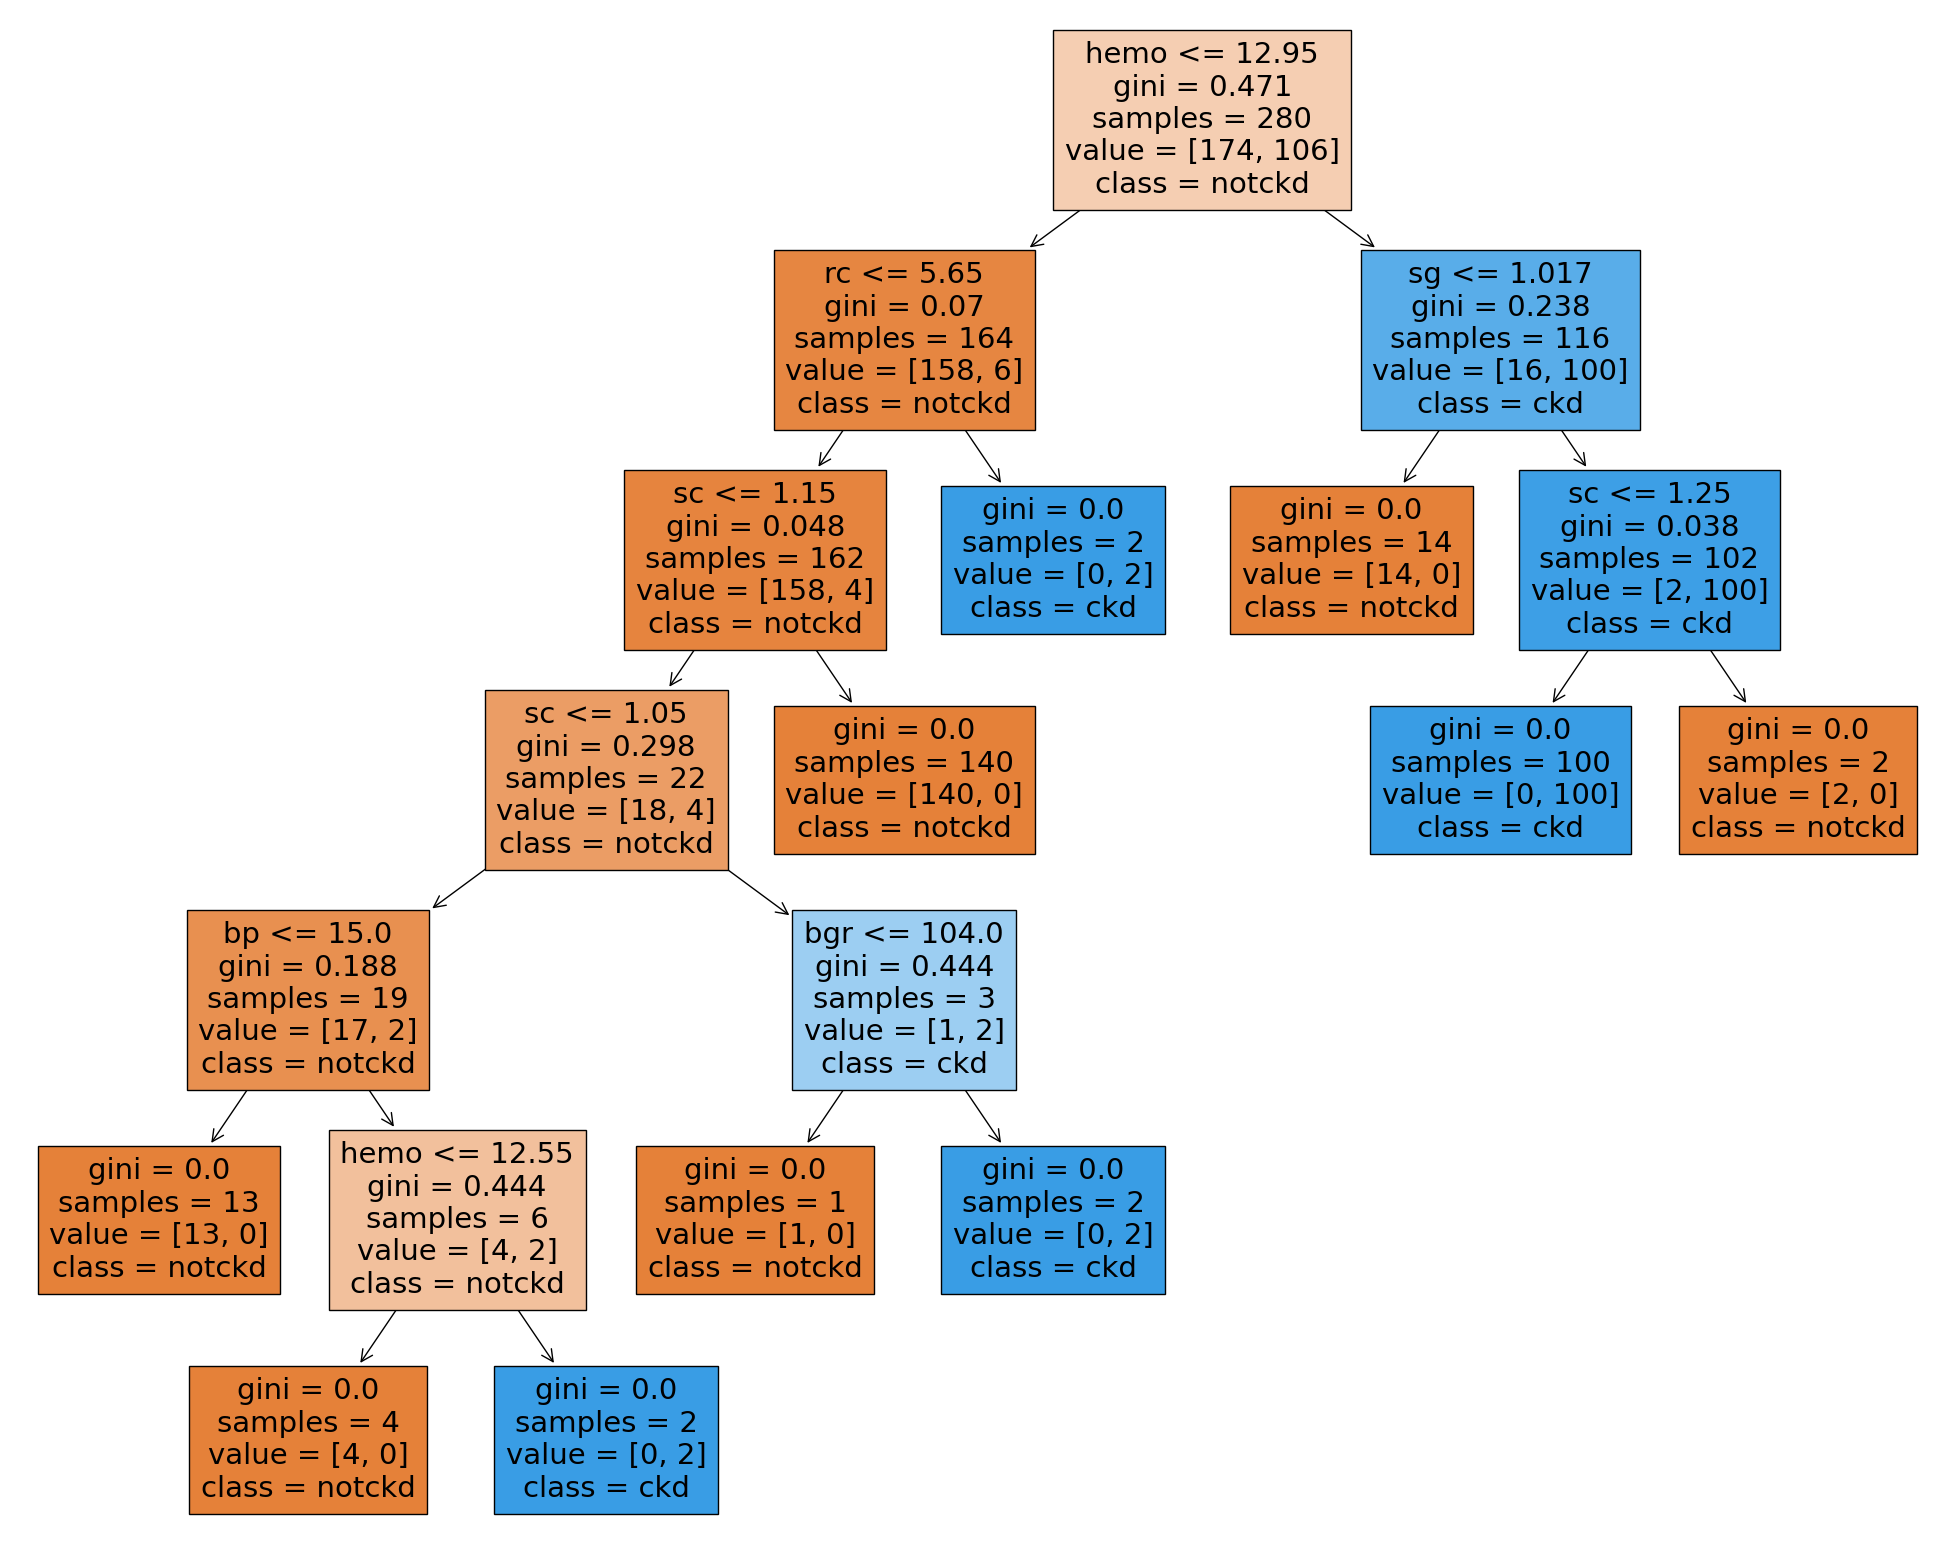

In [17]:
# dtc = DecisionTreeClassifier()


# cv_scores = cross_val_score(dtc, x_train, y_train, cv=5)

# print("Cross-validation scores:", cv_scores)
# print("Mean cross-validation score:", cv_scores.mean() * 100)

# # Fit model pada keseluruhan training set dan evaluasi pada test set
# model_no_prune = dtc.fit(x_train, y_train)
# dtc_acc = accuracy_score(y_test, dtc.predict(x_test))

# print(f"akurasi data training = {accuracy_score(y_train, dtc.predict(x_train))* 100}")
# print(f"akurasi data testing = {dtc_acc * 100} \n")

# confusion = confusion_matrix(y_test, dtc.predict(x_test))
# tn, fp, fn, tp = confusion.ravel()
# print(f"confusion matrix : \n{confusion} \n")
# print(f"classification report : \n{classification_report(y_test, dtc.predict(x_test))}")

# fig = plt.figure(figsize=(25, 20))

# _ = tree.plot_tree(model_no_prune, feature_names=ind_col, class_names=['notckd', 'ckd'], filled=True)

import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn import tree

# Menginisialisasi model
dtc = DecisionTreeClassifier()

# Mengukur waktu untuk cross-validation
start_time = time.perf_counter()
cv_scores = cross_val_score(dtc, x_train, y_train, cv=5)
end_time = time.perf_counter()
cv_time = end_time - start_time

print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean() * 100)
print(f"Time taken for cross-validation: {cv_time:.10f} seconds")

# Mengukur waktu untuk fitting model pada keseluruhan training set dan evaluasi pada test set
start_time = time.perf_counter()
model_no_prune = dtc.fit(x_train, y_train)
end_time = time.perf_counter()
fit_time = end_time - start_time

# Mengukur waktu untuk prediksi
start_time = time.perf_counter()
y_pred = dtc.predict(x_test)
end_time = time.perf_counter()
predict_time = end_time - start_time

dtc_acc = accuracy_score(y_test, y_pred)

print(f"Time taken for fitting model: {fit_time:.10f} seconds")
print(f"Time taken for prediction: {predict_time:.10f} seconds")

print(f"akurasi data training = {accuracy_score(y_train, dtc.predict(x_train)) * 100:.2f}")
print(f"akurasi data testing = {dtc_acc * 100:.2f} \n")

confusion = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion.ravel()
print(f"confusion matrix : \n{confusion} \n")
print(f"classification report : \n{classification_report(y_test, y_pred)}")

fig = plt.figure(figsize=(25, 20))
_ = tree.plot_tree(model_no_prune, feature_names=ind_col, class_names=['notckd', 'ckd'], filled=True)



Akurasi data training: 97.86%
Akurasi data testing: 99.17% 

Cross-validation scores:
Fold 1: 0.9750
Fold 2: 1.0000
Fold 3: 1.0000
Fold 4: 0.9500
Fold 5: 0.9750
Fold 6: 1.0000
Fold 7: 0.9750
Fold 8: 0.9500
Fold 9: 0.8750
Fold 10: 0.9750
Mean cross-validation score: 0.9675
Standard deviation of cross-validation scores: 0.0354

Confusion matrix:
[[75  1]
 [ 0 44]]

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        76
           1       0.98      1.00      0.99        44

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120

Precision: 0.9919
Recall: 0.9917
F1-Score: 0.9917


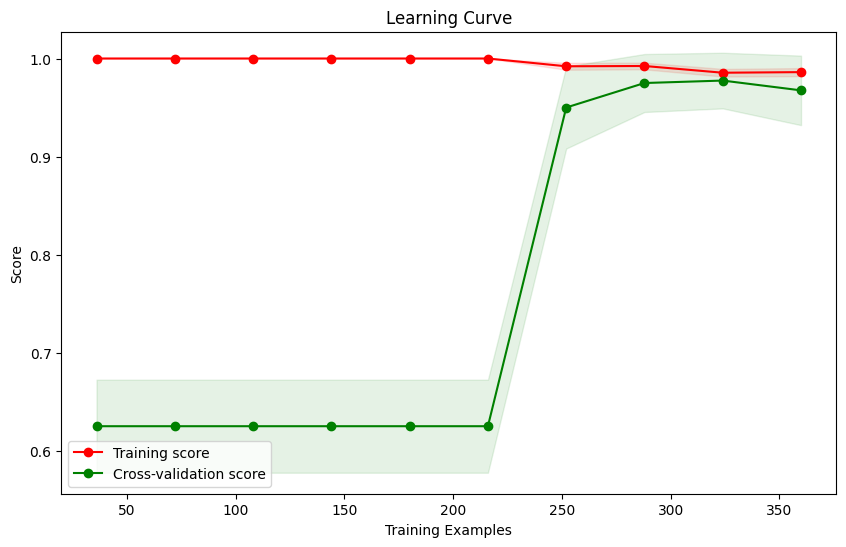

In [18]:
dtc = DecisionTreeClassifier(
    criterion='entropy',
    ccp_alpha=0.0134,
    random_state=42,
    max_depth=3
)

# Training model
model = dtc.fit(x_train, y_train)

# Evaluasi pada data testing
dtc_acc = accuracy_score(y_test, dtc.predict(x_test))
print(f"Akurasi data training: {accuracy_score(y_train, dtc.predict(x_train)) * 100:.2f}%")
print(f"Akurasi data testing: {dtc_acc * 100:.2f}% \n")

# Cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
cv_results = cross_val_score(model, x, y, cv=kf, scoring='accuracy')
print('Cross-validation scores:')
for i, score in enumerate(cv_results, 1):
    print(f'Fold {i}: {score:.4f}')
print(f'Mean cross-validation score: {np.mean(cv_results):.4f}')
print(f'Standard deviation of cross-validation scores: {np.std(cv_results):.4f}')

# Confusion matrix
confusion = confusion_matrix(y_test, dtc.predict(x_test))
print(f"\nConfusion matrix:\n{confusion}\n")
print(f"Classification report:\n{classification_report(y_test, dtc.predict(x_test))}")

# Precision, Recall, F1-Score
precision = precision_score(y_test, dtc.predict(x_test), average='weighted')
recall = recall_score(y_test, dtc.predict(x_test), average='weighted')
f1 = f1_score(y_test, dtc.predict(x_test), average='weighted')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Learning curve
train_sizes, train_scores, test_scores = learning_curve(dtc, x, y, cv=kf, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()

In [19]:
ccp_alpha_values = [4,2, 1.1, 1, 0.1, 0.0001, 0.001, 0.005, 0.010, 0.012, 0.0134]
results = []

for alpha in ccp_alpha_values:
    dtc = DecisionTreeClassifier(
        criterion='entropy',
        ccp_alpha=alpha,
        random_state=42,
        max_depth=3)
    model = dtc.fit(x_train, y_train)
    y_train_pred = dtc.predict(x_train)
    y_test_pred = dtc.predict(x_test)

    dtc_acc_train = accuracy_score(y_train, y_train_pred)
    dtc_acc_test = accuracy_score(y_test, y_test_pred)

    # Simpan hasil ke dalam list
    results.append({
        'ccp_alpha': alpha,
        'Akurasi Data Training (%)': dtc_acc_train * 100,
        'Akurasi Data Testing (%)': dtc_acc_test * 100,
        'Unique Predictions Training': np.unique(y_train_pred),
        'Unique Predictions Testing': np.unique(y_test_pred)
    })

# Konversi hasil ke DataFrame untuk ditampilkan
results_df = pd.DataFrame(results)
print(results_df)


    ccp_alpha  Akurasi Data Training (%)  Akurasi Data Testing (%)  \
0      4.0000                  62.142857                 63.333333   
1      2.0000                  62.142857                 63.333333   
2      1.1000                  62.142857                 63.333333   
3      1.0000                  62.142857                 63.333333   
4      0.1000                  97.142857                 99.166667   
5      0.0001                  97.857143                 99.166667   
6      0.0010                  97.857143                 99.166667   
7      0.0050                  97.857143                 99.166667   
8      0.0100                  97.857143                 99.166667   
9      0.0120                  97.857143                 99.166667   
10     0.0134                  97.857143                 99.166667   

   Unique Predictions Training Unique Predictions Testing  
0                          [0]                        [0]  
1                          [0]         